
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Make a Synthetic Dataset to Demonstrate Variogram Structures

Flexible tool to make a spatial, univariatevariate datasets for variogram demonstrations and testing new methods

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Import Required Packages

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import geostatspy.geostats as geostats    # reimplimentation of GSLIB algorithms in Python
import geostatspy.GSLIB as GSLIB          # GSLIB visualization, subroutines and algorithm wrappers
cmap = plt.cm.inferno                     # color map
import seaborn as sns
from copy import copy                     # deep copies
from scipy import signal                  # 2D convolution
from scipy.ndimage import distance_transform_cdt # distance transform to taper convolution kernel to avoid realization discontinuities
import math                               # square root

#### Some Truth Model Parameters

In [20]:

# Make the variogram object
# vario = GSLIB.make_variogram(nug,nst=1,it1=it,cc1=1-nug,azi1=azi,hmaj1=hmaj,hmin1=hmin) # make model object

# Make the dummy dataset (should be outside the range of correlation of the model)
name = 'lithium'

df = pd.DataFrame({'X':np.full(100,-9999),'Y':np.full(100,-9999),name:np.random.normal(0.0,1.0,100)})

# Truth Model Grid Parameters
nx = 100; ny = 100                        # number of cells in the x and y directions
csiz = 10.0; xsiz = 10.0; ysiz = 10.0     # size of the cells in the x and y directions
xmn = xsiz * 0.5; ymn = ysiz * 0.5        # assume origin at 0,0, calculate the 1 cell centroid
xmin = xmn - 0.5*xsiz; ymin = ymn - 0.5*ysiz # assume origin at 0,0, calculate the min and max x/y coordinates
xmax = xmin + nx * xsiz; ymax = ymin + ny * ysiz;
vmin = 0; vmax = 2000.0                   # feature min and max for color bars

Note, I've been really busy, this could have been cleaned up and generalized better. Anyone want to jump in and make this a easy to use tool? It is close and really useful.

#### Declare Functions

I coded up the following functions to sample from the truth model.  These include the following operations:

**regular_sample_MV** 

Function for regular sampling from an exhaustive truth model, a 2D ndarray

* **array** - 2D ndarray with the truth model for feature 1
* **array2** - 2D ndarray with the truth model for feature 2
* **array3** - 2D ndarray with the truth model for feature 3
* **array4** - 2D ndarray with the truth model for feature 4
* **xmin** - minimum x coordinate - truth model extents
* **xmax** - maximum x coordinate
* **ymin** - minimum y coordinate
* **ymax** - maximum y coordinate
* **spacing** - spacing of the samples in x and y
* **minsx** - minimum x coordinate of the samples - sampling window, defaults to extend of the array
* **maxsx** - maximum x coordinate of the samples
* **minsy** - minimum y coordinate of the samples
* **maxsy** - maximum y coordinate of the samples
* **name** - feature 1 name
* **name2** - feature 2 name
* **name3** - feature 3 name
* **name4** - feature 4 name

**random_sample_MV** 

Funciton for random sample from an exhaustive truth model, a 2D ndarray

* **array** - 2D ndarray with the truth model for feature 1
* **array2** - 2D ndarray with the truth model for feature 2
* **array3** - 2D ndarray with the truth model for feature 3
* **array4** - 2D ndarray with the truth model for feature 4
* **xmin** - minimum x coordinate - truth model extents
* **xmax** - maximum x coordinate
* **ymin** - minimum y coordinate
* **ymax** - maximum y coordinate 
* **nsamp** - number of random samples
* **minsx** - minimum x coordinate of the samples - sampling window, defaults to extend of the array
* **maxsx** - maximum x coordinate of the samples
* **minsy** - minimum y coordinate of the samples
* **maxsy** - maximum y coordinate of the samples
* **name** - feature 1 name
* **name2** - feature 2 name
* **name3** - feature 3 name
* **name4** - feature 4 name

**rejection_sample** 

Function to preferentially remove high/low samples from a DataFrame to impose sampling bias

* **df** - DataFrame with the sample data
* **vcol** - feature of interest for the rejection decision, all features are preserved in the output DataFrame
* **frac** - fraction of dataset to remove with the rejection sampler
* **wt_min** - weight for the minimum value - linear interpolation used to assign weights from min to max value 
* **wt_max** - weight for the maximum value

Here's the functions:

In [21]:
def regular_sample(array,xmin,xmax,ymin,ymax,spacing,
                      minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value'):
    x = []; y = []; v = []
    nx = array.shape[1]; ny = array.shape[0]
    xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
    xmn = xmin + 0.5*xsiz; ymn = ymin + 0.5*ysiz
    xx, yy = np.meshgrid(np.arange(xmin, xmax, spacing), np.arange(ymax, ymin, -1 * spacing))
    xx = xx + spacing*0.5; yy = yy - spacing*0.5
    for ix,iy in np.ndindex(xx.shape):
        iix = geostats.getindex(nx,xmn,xsiz,xx[iy,ix])
        iiy = geostats.getindex(ny,ymn,ysiz,yy[iy,ix])
        if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy: 
            if xx[iy,ix] >= minsx and xx[iy,ix] >= minsx: 
                x.append(xx[iy, ix])
                y.append(yy[iy, ix])
                v.append(array[ny - iiy - 1, iix])
    df = pd.DataFrame(np.c_[x, y, v], columns=["X", "Y", name])
    return df

def random_sample(array,xmin,xmax,ymin,ymax,nsamp=10,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name='Value'):
    x = []; y = []; v = []
    ny, nx = array.shape   
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax,(xmax-xmin)/float(nx)), np.arange(ymax - 1, ymin - 1, -1 * (ymax-ymin)/float(ny))
    )
    mask = np.zeros([ny,nx])
    for iy in range(0,ny):
        for ix in range(0,nx):
            if xx[iy,ix] >= minsx and xx[iy,ix] <= maxsx:
                if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy:
                    mask[iy,ix] = 1.0
    
    if nsamp*1.2 > np.sum(mask):
        print('ERROR - too few locations available for number of samples requested!') 
        return pd.DataFrame()
    isamp = 0
    while isamp < nsamp:
        sample_index = np.random.choice(range(nx * ny), 1)
        iy = int(sample_index[0] / ny)
        ix = sample_index[0] - iy * nx
        if mask[iy,ix] == 1:    
            if xx[iy,ix] >= xmin and xx[iy,ix] <= xmax:
                if yy[iy,ix] >= ymin and yy[iy,ix] <= ymax:        
                    x.append(xx[iy, ix])
                    y.append(yy[iy, ix])
                    v.append(array[iy, ix])      
                    mask[iy,ix] = 0.0
                    isamp = isamp + 1
    df = pd.DataFrame(np.c_[x, y, v], columns=["X", "Y", name])
    return df

def rejection_sample(df,vcol,frac,wt_min,wt_max):
    value = [np.min(df[vcol].values),np.max(df[vcol].values)]
    wt = [wt_min,wt_max]
    df_copy = df.copy(deep = True)
    df_copy['weights'] = np.interp(df[vcol],value,wt)
    df_sample = df_copy.sample(frac = frac, replace = False, weights = 'weights')
    return df_sample

#### Declare Functions to Make Model Components

I have coded some functions to make the follow spatial trend components:

* linear trend
* spatial continuity with an unconditional convolution approach

In [22]:
def linear_trend(nx,ny,csiz,azi,mean=0.0,var=1.0):   # model with linear trend
    xx, yy = np.meshgrid(np.arange(csiz*0.5,nx*csiz, csiz),np.arange(ny*csiz-csiz*0.5,0,-1*csiz))
    cos_angle = np.cos(np.radians(azi+270)); sin_angle = np.sin(np.radians(azi+270))
    xc = xx - nx*csiz*0.5; yc = yy - ny*csiz*0.5
    trend = xc * cos_angle - yc * sin_angle
    trend = GSLIB.affine(trend,mean,math.sqrt(var))
    return trend

def distance_function(x):                              # mathematical geomorphology distance transform 
    x = np.pad(x, 1, mode='constant')
    dist = distance_transform_cdt(x, metric='taxicab')
    return dist[1:-1, 1:-1]
# from https://stackoverflow.com/questions/40492159/find-distance-from-the-edge-of-a-numpy-array

def make_anisotropic_kernel(nkern,csiz,azi,a_maj,a_min,distance=True,stand=True):     # make a convolutional kernel
    kern = np.ones((nkern,nkern))
    xx, yy = np.meshgrid(np.arange(csiz*0.5,nkern*csiz, csiz),np.arange(nkern*csiz-csiz*0.5,0,-1*csiz))
    cos_angle = np.cos(np.radians(azi+90)); sin_angle = np.sin(np.radians(azi+90))
    xc = xx - nkern*csiz*0.5; yc = yy - nkern*csiz*0.5
    xct = xc * cos_angle - yc * sin_angle; yct = xc * sin_angle + yc * cos_angle 
    rad_cc = (xct**2/(a_maj**2)) + (yct**2/(a_min**2))
    kern[rad_cc>1.0] = 0.0
    if distance:
        kern = distance_function(kern) 
    if stand:
        kern = kern/np.sum(kern)
    return kern

def uncond_sim(nx,ny,csiz,azi,a_maj,a_min,mean=0.0,var=1.0):
    nkern = int(a_maj/csiz+10)
    kern = make_anisotropic_kernel(nkern,csiz,azi,a_maj,a_min,True,True)
    kern = distance_function(kern)
    kern = kern/np.sum(kern)
    sim = np.random.normal(loc=0.0,scale=1.0,size=[ny+nkern,nx+nkern])
    sim = GSLIB.affine(signal.convolve2d(sim,kern,mode='same')[int(nkern/2):int(ny+nkern/2),int(nkern/2):int(nx+nkern/2)],mean,math.sqrt(var))   
    return sim

#### Build a Compositional Model

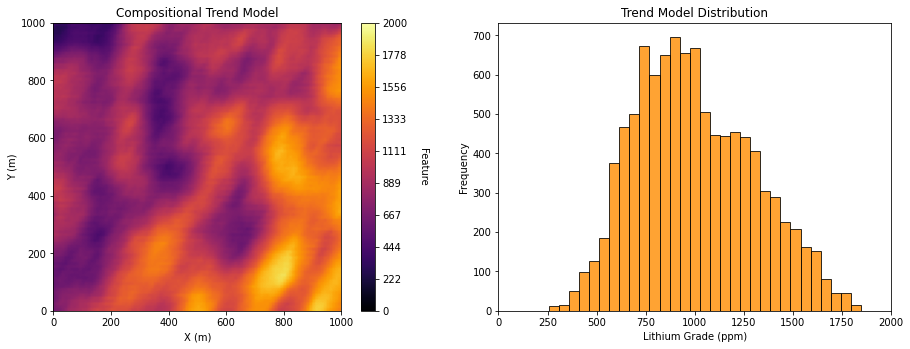

In [35]:
corr_var = 0.5; corr_azi = 25; corr_a_maj = 200; corr_a_min = 100
linear_var = 0.5; linear_azi = 115
nugget_var = 1.0 - (corr_var + linear_var)
tmean = 1000.0; tstdev = 300.0

nugget = np.random.normal(loc=0.0,scale=math.sqrt(nugget_var),size=[ny,nx])
corr = uncond_sim(nx,ny,csiz,corr_azi,corr_a_maj,corr_a_min,0.0,corr_var)
linear = linear_trend(nx,ny,csiz,linear_azi,0.0,linear_var)

model = nugget + corr + linear
model = GSLIB.affine(model,tmean,tstdev)

plt.subplot(121)
im = plt.imshow(model,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
plt.title('Compositional Trend Model')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10))
cbar.set_label('Feature', rotation=270, labelpad=20)

plt.subplot(122)
plt.hist(model.flatten(),bins=np.linspace(0,2000,40),color='darkorange',alpha=0.8,edgecolor='black')
plt.xlabel('Lithium Grade (ppm)'); plt.ylabel('Frequency'); plt.title('Trend Model Distribution')
plt.xlim([0,2000])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

#### Sample from the Truth Model for Each Feature

The following sampling workflow includes the following steps:

1. Apply Regular Sampling
2. Apply Random Sampling
3. Combine the Regular and Random Samples
4. Apply Rejection Sampling to Impose Bias
5. Remove Spatial Duplicates 

We check for and remove spatial duplicates, while each step will not produce duplicates (samples coincidental in space), this is a low probability of this occuring between steps.

* spatial duplicates cause analysis issues such as singular matrices for kriging etc.

You can adjust the following parameters to customize your sample set:

* **spacing** - the interwell spacing in x and y of the regular samples
* **nrandom_sample** - the number of random samples
* **wt_min** - the relative weight of the lowest value - linear interpolation is applied between min and max values
* **wt_max** - the relative weight of the highest value
* **bias_frac** -the proportion of the dataset to reject

Some other ideas:

* limit the regular and random samples to subsets of the truth model (use minsx,maxsx,minsy,maxsy)
* use multiple regular sample sets over different parts of the truth model
* use multiple random sample sets over different parts of the truth model with different sampling densities
* change the random number seed to get multiple datasets with the same sampling parameters

With the provided operations there is a lot of flexibility to build a unique sample set. The following workflow is a simple demonstration:

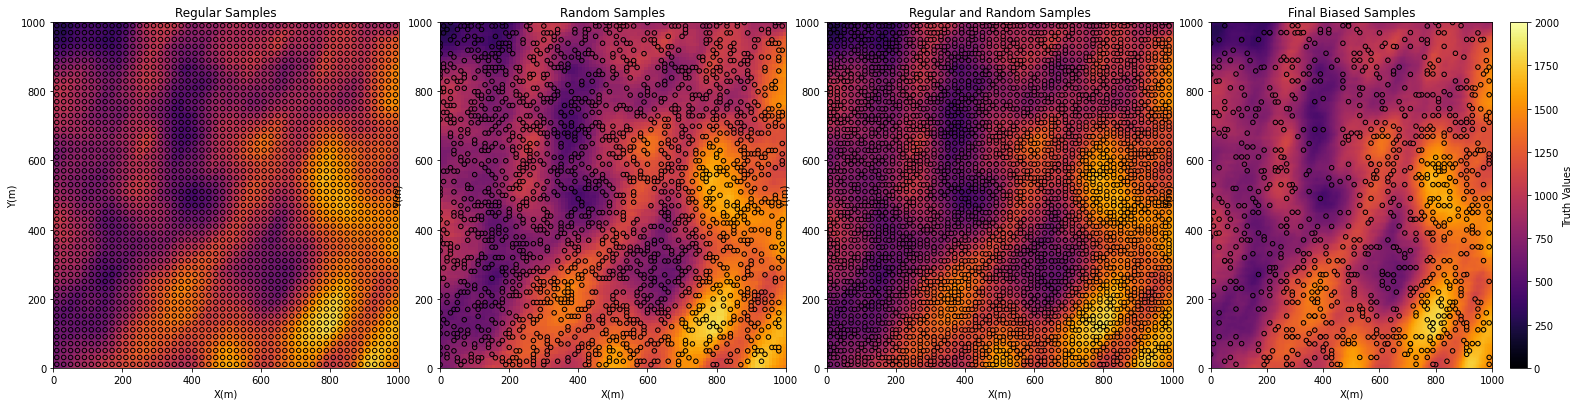

Number of data - 900


In [37]:
# Data Set Sampling Paramters
spacing = 20                              # spacing of regular samples
nrandom_sample = 2000                      # number of random samples
wt_min = 0.1; wt_max = 1.0                # weigths of minimum and maximum feature values - control on degree of bias 
bias_frac = 0.8                           # fraction of dataset to remove with rejection sampler
seed = 73073                              # random number seed
vmin = 0.0; vmax = 2000.0

np.random.seed(seed = seed)               # set the random number seed for repeatability of samples

# Regular Sampling
regular_samples = regular_sample(model,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,spacing=spacing,
                         minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name="Lithium")

# Random Sampling
random_samples = random_sample(model,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
                               nsamp = nrandom_sample,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,
                               name="Lithium")

# Concatenate (Combine) Regular and Random Samples into One DataFrame  
samples = pd.concat([regular_samples,random_samples])

# Rejection Sampler
biased_samples = rejection_sample(samples,"Lithium",1-bias_frac,wt_min,wt_max)

# Remove Dupicates 
biased_samples = biased_samples[np.invert(biased_samples.duplicated(subset=['X','Y'],keep='first'))] 

# Drop the weights column
biased_samples = biased_samples.drop('weights',axis=1)  

# Visualize Each Step of the Process and the Final Sample Set and Truth Model
plt.subplot(141)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Regular Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(model,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(regular_samples['X'],regular_samples['Y'],c = regular_samples["Lithium"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Regular Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(142)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Random Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(model,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(random_samples['X'],random_samples['Y'],c = random_samples["Lithium"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Random Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(143)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Regular and Random Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(model,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(samples['X'],samples['Y'],c = samples["Lithium"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Regular and Random Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])

plt.subplot(144)
plt.xlabel('X(m)'); plt.ylabel('Y(m)')
plt.title('Final Biased Samples')  
palette = copy(plt.cm.inferno)
palette.set_under('r', 0.0)
palette.set_over('r', 0.0)
plt.imshow(model,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = palette)
plt.scatter(biased_samples['X'],biased_samples['Y'],c = biased_samples["Lithium"],s = 20, cmap = palette,vmin = vmin, vmax = vmax, 
                        edgecolors = 'black',label = 'Biased Samples')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
ax4 = plt.gca()
cbar = plt.colorbar()
cbar.set_label('Truth Values')
ax4.set_aspect('auto')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.5, top=1.2, wspace=0.1, hspace=0.2)
plt.show()  

biased_samples = biased_samples.reset_index()

print('Number of data - ' + str(len(biased_samples)))

we visualize the results for porosity only above so we can check each of the sampling steps.

#### Variogram Map

In [ ]:
vmap, npmap = varmapv(df,'X','Y','NPor',tmin=-999,tmax=999,nxlag=11,nylag=11,dxlag=50,dylag=50,minnp=1,isill=1)

xmin = -575;ymin = -575; xmax = 575; ymax = 575; step = 50; vmin = 0.0; vmax = 1.6 
plt.subplot(111)
xx, yy = np.meshgrid(np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step))
#im = plt.contourf(xx,yy,vmap,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin, vmax, 100),)
im = plt.imshow(vmap,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = vmin, vmax = vmax,cmap = cmap)
plt.title('Variogram Map'); plt.xlabel('X Offset (m)'); plt.ylabel('Y Offset (m)')
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10))
cbar.set_label('Variogram Value', rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

print('The shape of the output is ' + str(vmap.shape))

In [ ]:
#biased_samples = biased_samples.reset_index()
biased_samples = biased_samples.drop(['index','Facies'],axis=1)
biased_samples.head()

That looks really awesome! I like it. If you want to change it, there are plenty of options to change the truth models and the sampling design.

Let's also check the by-facies MV relationships with a matrix scatter plot.

#### Save the Truth Model and Sample Data

Now we finish up by saving the truth model and sample data. 

* sample data DataFrame (biased_sample) will be saved to a '.csv'

* truth model (sim) will be saved to a 

More information and examples for loading and saving data with [DataFrames](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_DataFrame.ipynb) and [ndarrays](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_ndarrays.ipynb).

We will complete the following steps:

1. set the working directory, target for the saved files

2. save the sample set 

3. save the truth model

In [ ]:
biased_samples.head()

In [ ]:
import os
os.chdir('c:/PGE383')
biased_samples.to_csv('spatial_nonlinear_MV_facies_v6_sand_only.csv')

#### Comments

It is helpful to be able to general reasonable/realistic dataset. I hope that this is helpful.

I'm always happy to discuss,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin